Παραδοτέο 2: Υπολογιστική Ανάλυση

Χρησιμοποιήστε ενσωματώσεις λέξεων (Word2Vec, GloVe, FastText, BERT(embeddings), κ.λπ.)* και δικές σας -custom- αυτόματες ροές εργασίας NLP (προεπεξεργασία, λεξιλόγιο, ενσωμάτωση λέξεων, εννοιολογικά δέντρα κλπ) για να αναλύσετε την ομοιότητα των λέξεων πριν και μετά την ανακατασκευή. Υπολογίστε βαθμολογίες συνημιτόνου (cosine similarity) μεταξύ των αρχικών και των ανακατασκευασμένων εκδοχών. Συγκρίνετε τις μεθόδους ως προς τα A, B του παραδοτέου

Οπτικοποιήστε τις ενσωματώσεις λέξεων για τα Α,B χρησιμοποιώντας PCA/t-SNE για να αποδείξετε τις μετατοπίσεις στον σημασιολογικό χώρο.

Similarity results:
      orig recon  sim_sbert  sim_w2v  sim_fasttext  sim_glove  sim_custom
orig_text1  A_r1   0.955165 0.968501      0.991058   0.996619    0.940469
orig_text2  A_r2   0.909416 0.963927      0.986565   0.994937    0.953930
orig_text1  B_r1   0.946423 0.972284      0.979915   0.996896    0.980406
orig_text2  B_r2   0.935376 0.986547      0.995074   0.998173    0.988091
orig_text1  C_r1   0.957896 0.980137      0.989878   0.998139    0.984891
orig_text2  C_r2   0.974371 0.994935      0.998002   0.999290    0.993604
Saved similarity_results.csv


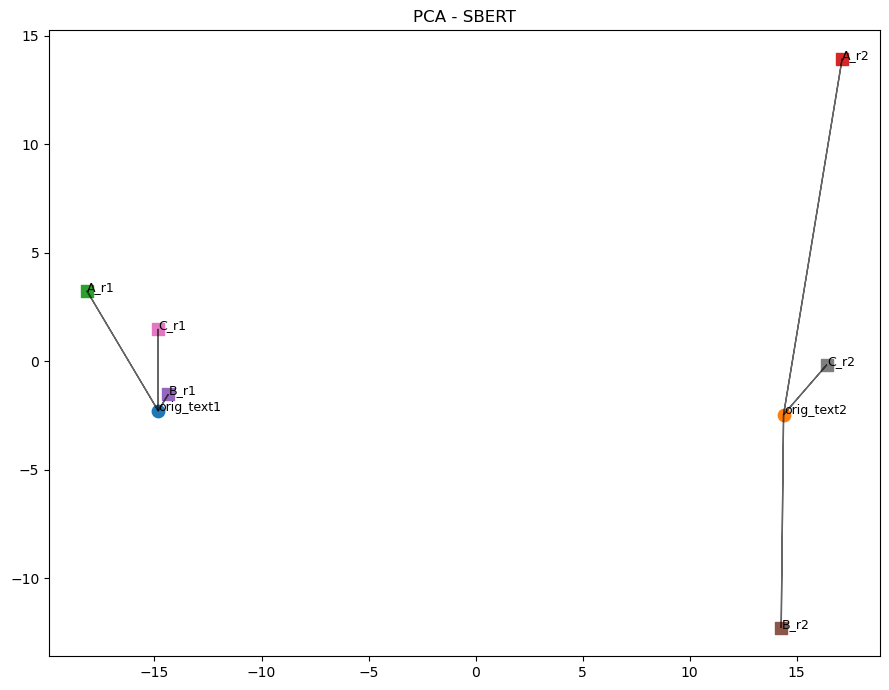

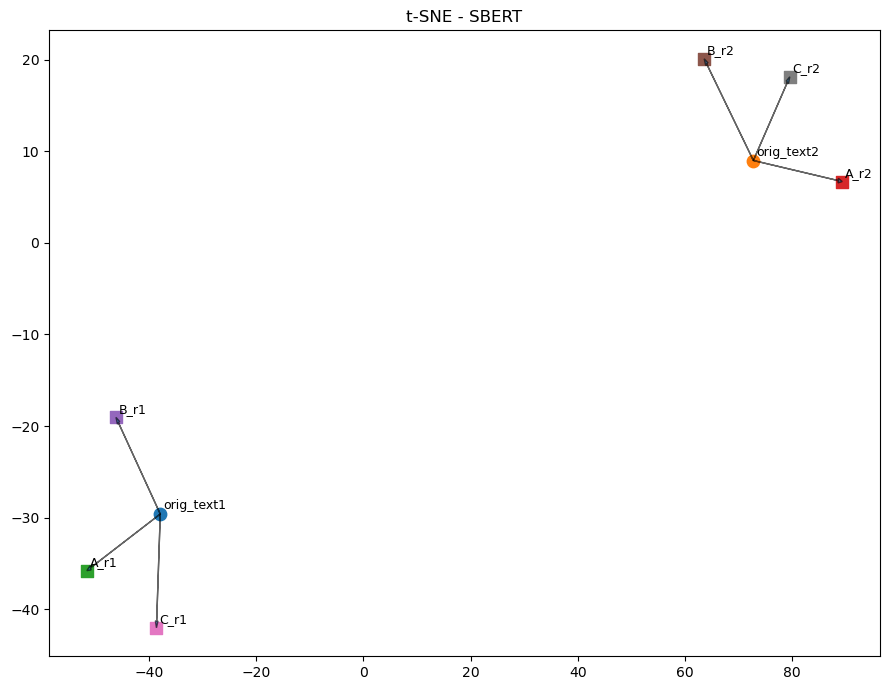

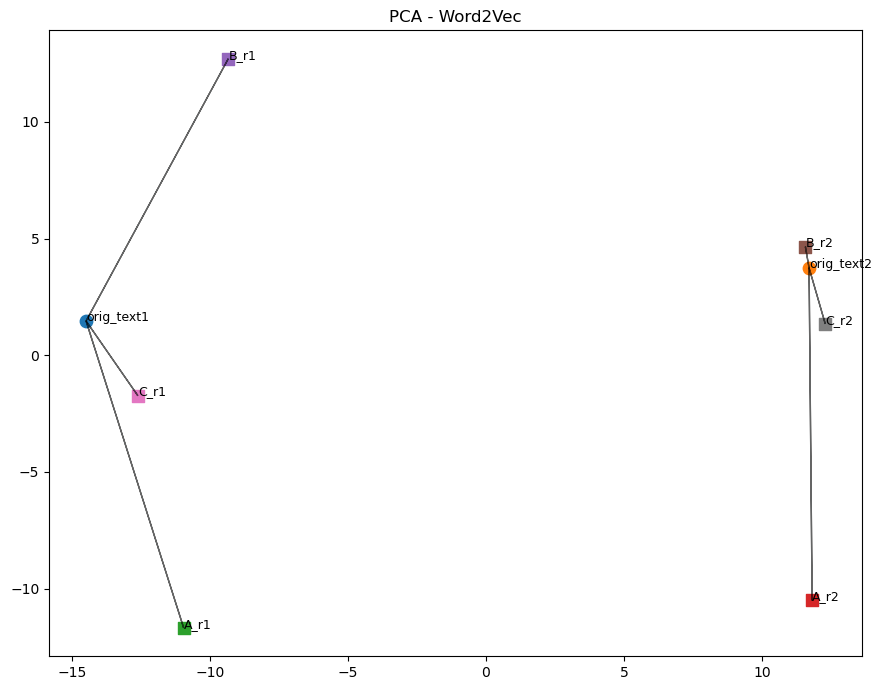

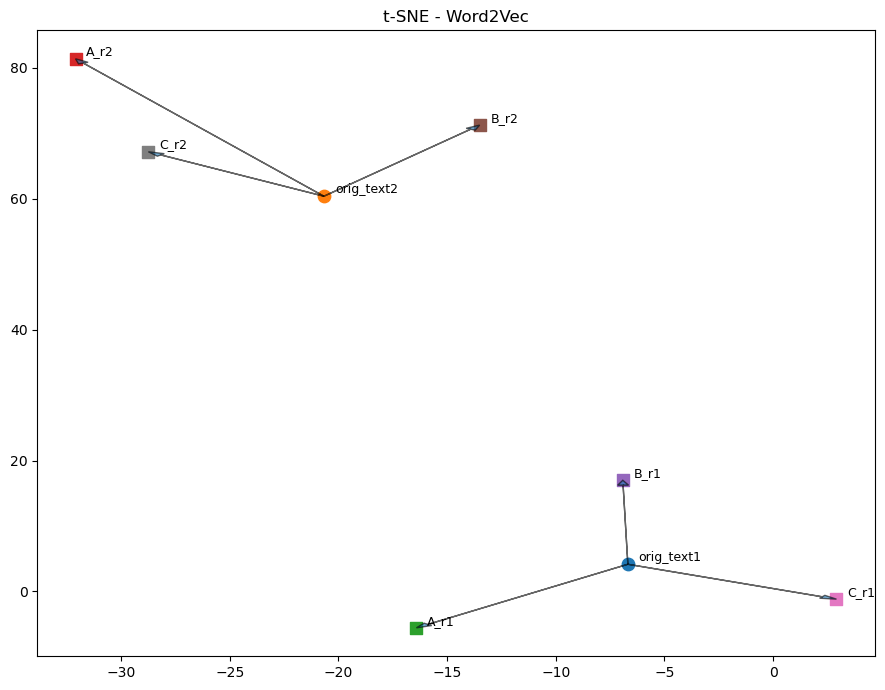

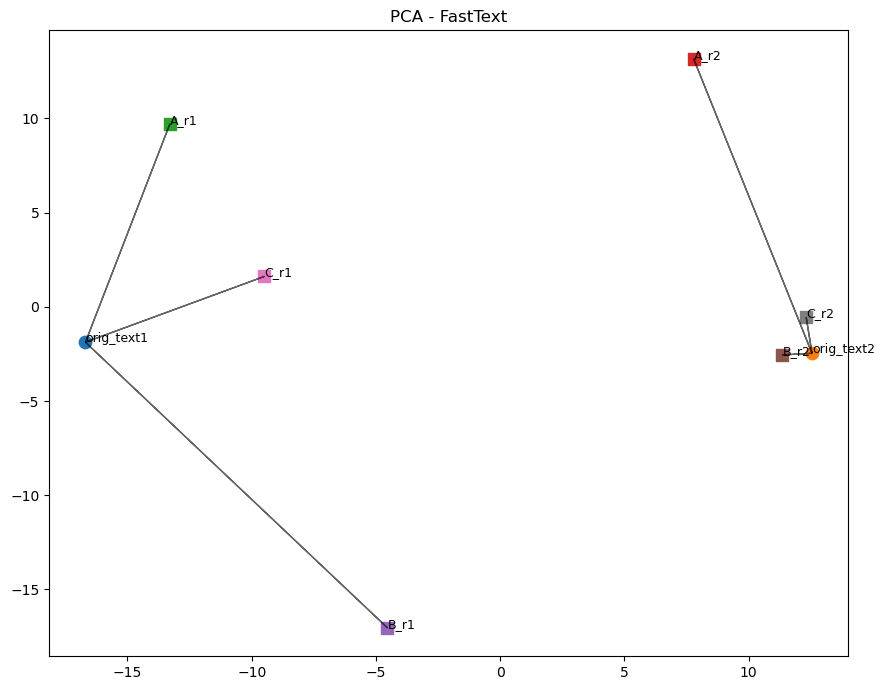

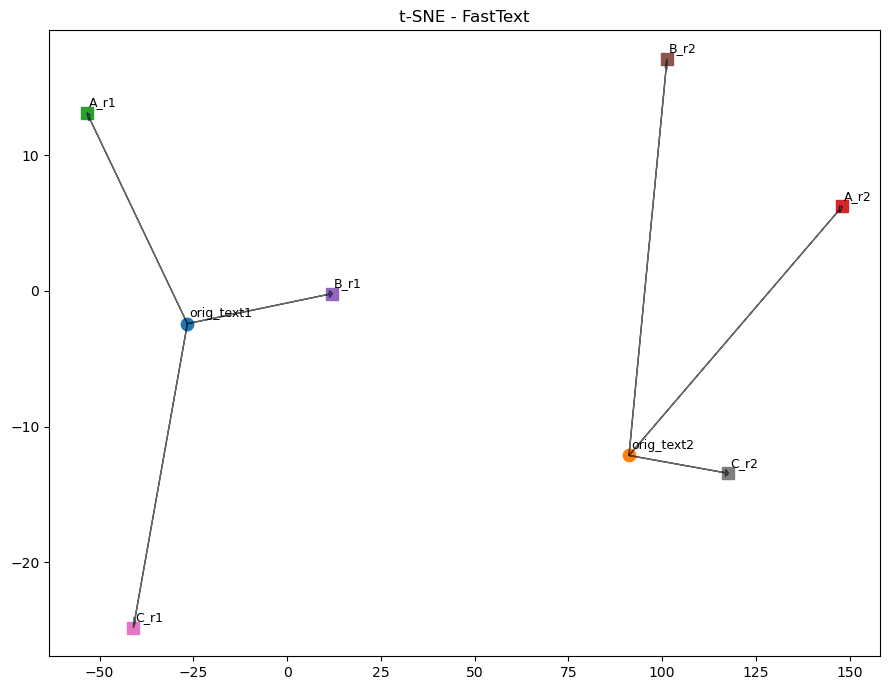

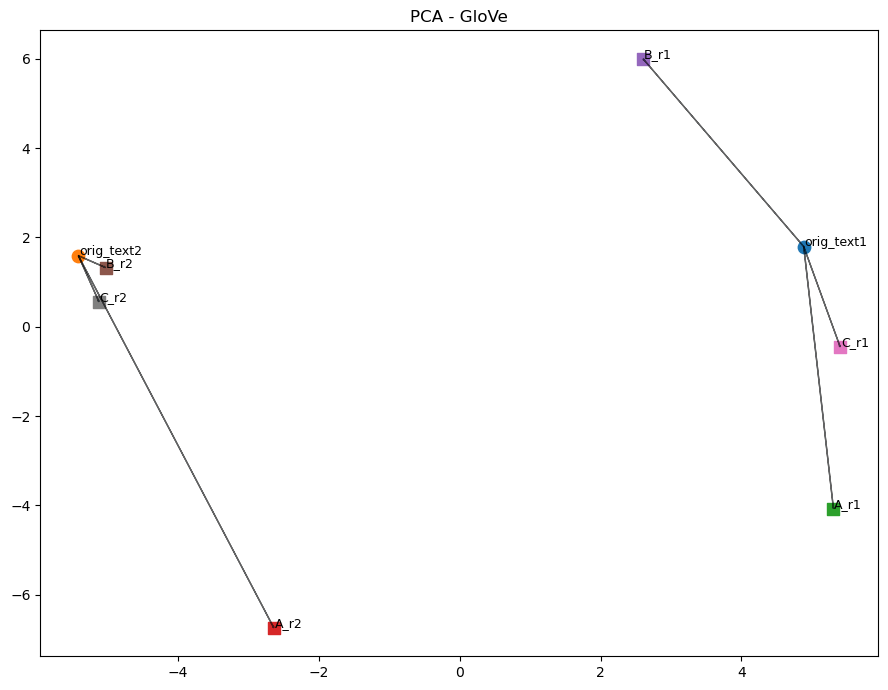

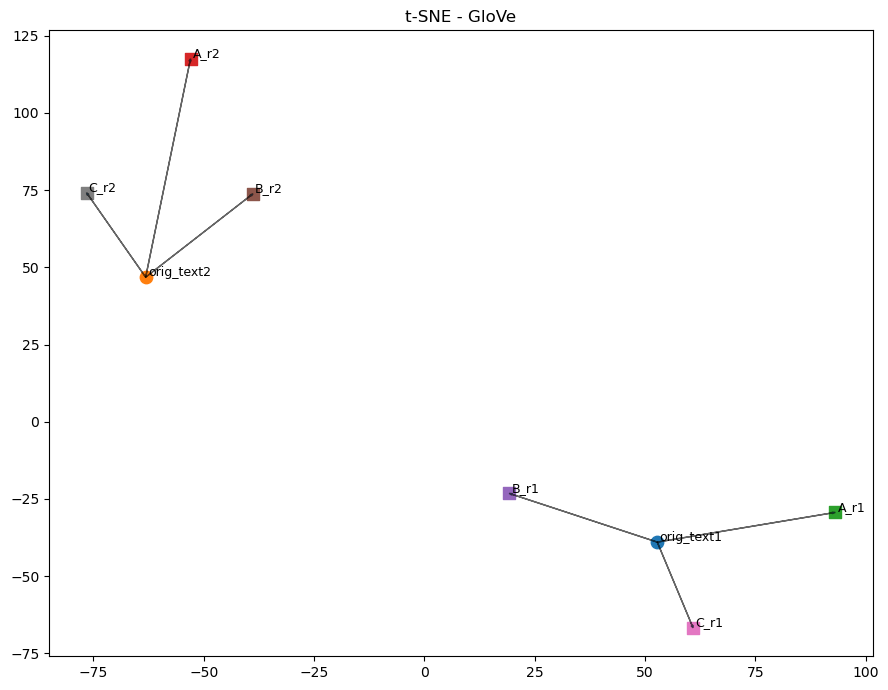

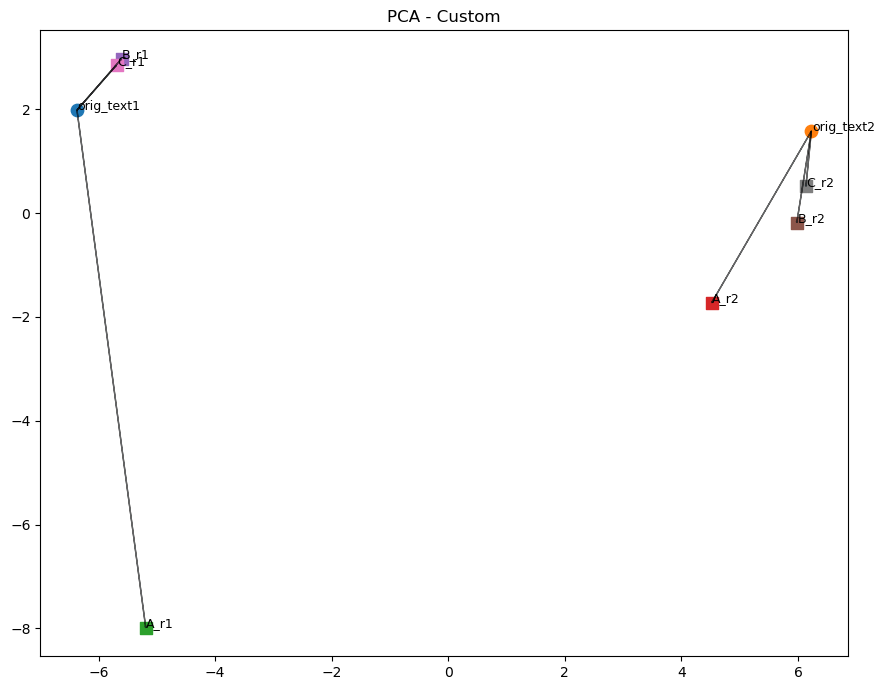

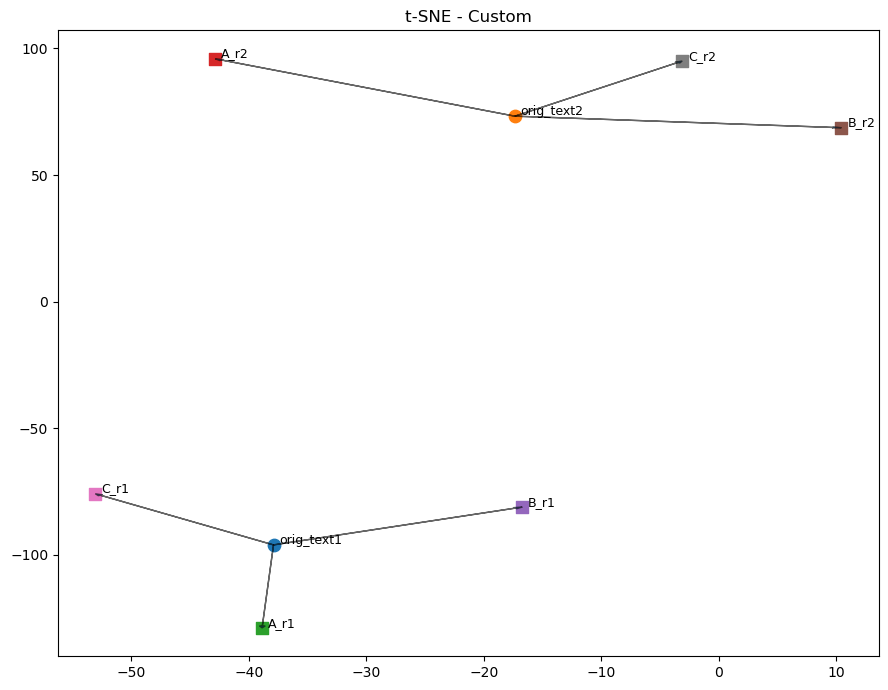

In [1]:
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
import re
from typing import List
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import gensim.downloader as api
from sentence_transformers import SentenceTransformer

def tokenize(text: str) -> List[str]:
    text = text.lower().replace("’", "'")
    text = re.sub(r"[^a-z0-9'\s]", " ", text)
    return [tok for tok in re.split(r"\s+", text) if tok]

def plot_pca_tsne(embeddings, pairs, labels, method_name):
    names = list(embeddings.keys())
    X = np.vstack([embeddings[n] for n in names])
    # Replace NaNs with zeros
    X = np.nan_to_num(X)
    # If all vectors are zero, skip plotting
    if np.all(X == 0) or np.isnan(X).any():
        print(f"Skipping plot for {method_name}: all embeddings are zero or contain NaN.")
        return
    names_idx = {n: i for i, n in enumerate(names)}
    disp_labels = {n: (labels[n] if labels and n in labels else n) for n in names}

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    pca = PCA(n_components=2)
    Xp = pca.fit_transform(Xs)

    plt.figure(figsize=(9,7))
    for i, n in enumerate(names):
        plt.scatter(Xp[i,0], Xp[i,1], marker="o" if n.startswith("orig_") else "s", s=80)
        plt.text(Xp[i,0]+0.01, Xp[i,1]+0.01, disp_labels[n], fontsize=9)
    for (a,b) in pairs:
        ia, ib = names_idx[a], names_idx[b]
        plt.arrow(Xp[ia,0], Xp[ia,1], Xp[ib,0]-Xp[ia,0], Xp[ib,1]-Xp[ia,1], head_width=0.02, length_includes_head=True, alpha=0.6)
    plt.title(f"PCA - {method_name}")
    plt.tight_layout()
    plt.savefig(Path("plots") / f"PCA - {method_name}")
    plt.show()

    tsne = TSNE(perplexity=3)
    Xt = tsne.fit_transform(Xs)

    plt.figure(figsize=(9,7))
    for i, n in enumerate(names):
        plt.scatter(Xt[i,0], Xt[i,1], marker="o" if n.startswith("orig_") else "s", s=80)
        plt.text(Xt[i,0]+0.5, Xt[i,1]+0.5, disp_labels[n], fontsize=9)
    for (a,b) in pairs:
        ia, ib = names_idx[a], names_idx[b]
        plt.arrow(Xt[ia,0], Xt[ia,1], Xt[ib,0]-Xt[ia,0], Xt[ib,1]-Xt[ia,1], head_width=0.5, length_includes_head=True, alpha=0.6)
    plt.title(f"t-SNE - {method_name}")
    plt.tight_layout()
    plt.savefig(Path("plots") / f"t-SNE - {method_name}")
    plt.show()

def mean_vectors(tokens, model):
    vecs = [model[t] for t in tokens if t in model]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size, dtype=float)

def compute_cosine(a, b):
    return float(cosine_similarity([a], [b])[0,0])

def main():
    # INITIALIZATION OF DATA

    originals = {
        "text1": ("Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in "
              "our lives. Hope you too, to enjoy it as my deepest wishes. Thank your message to show our words to the "
              "doctor, as his next contract checking, to all of us. I got this message to see the approved message. "
              "In fact, I have received the message from the professor, to show me, this, a couple of days ago. "
              "I am very appreciated the full support of the professor, for our Springer proceedings publication"),
        "text2": ("During our final discuss, I told him about the new submission — the one we were waiting since last "
              "autumn, but the updates was confusing as it not included the full feedback from reviewer or maybe "
              "editor? Anyway, I believe the team, although bit delay and less communication at recent days, they "
              "really tried best for paper and cooperation. We should be grateful, I mean all of us, for the "
              "acceptance and efforts until the Springer link came finally last week, I think. Also, kindly remind me "
              "please, if the doctor still plan for the acknowledgments section edit before he sending again. "
              "Because I didn’t see that part final yet, or maybe I missed, I apologize if so. Overall, "
              "let us make sure all are safe and celebrate the outcome with strong coffee and future targets")
    }

    with open("outputs_of_B.txt", "r", encoding="utf-8") as f:
        lines = f.readlines()
        reconstructed = {
            "A": {"r1": lines[1], "r2": lines[4]},
            "B": {"r1": lines[7], "r2": lines[10]},
            "C": {"r1": lines[13], "r2": lines[16]}
        }

    pairs = [
        ("orig_text1", "A_r1"),
        ("orig_text2", "A_r2"),
        ("orig_text1", "B_r1"),
        ("orig_text2", "B_r2"),
        ("orig_text1", "C_r1"),
        ("orig_text2", "C_r2")
    ]

    corpus = list(originals.values()) + [v for grp in reconstructed.values() for v in grp.values()]
    tokenized_corpus = [tokenize(t) for t in corpus]

    # PRE-TRAINED MODELS

    w2v = api.load("word2vec-google-news-300")
    ft = api.load("fasttext-wiki-news-subwords-300")
    glove = api.load("glove-wiki-gigaword-50")
    sbert = SentenceTransformer("all-MiniLM-L6-v2")

    all_texts = {f"orig_{k}": v for k,v in originals.items()}
    for grp, d in reconstructed.items():
        for k,v in d.items():
            all_texts[f"{grp}_{k}"] = v

    keys = list(all_texts.keys())
    sentences = [all_texts[k] for k in keys]

    sbert_embs_dict = {k: v for k, v in zip(keys, sbert.encode(sentences))}
    w2v_embs_dict = {k: mean_vectors(tokenize(all_texts[k]), w2v) for k in keys}
    ft_embs_dict = {k: mean_vectors(tokenize(all_texts[k]), ft) for k in keys}
    glove_embs_dict = {k: mean_vectors(tokenize(all_texts[k]), glove) for k in keys}

    # CUSTOM
    # Build vocabulary from all tokens in the corpus
    counter = Counter(tok for doc in tokenized_corpus for tok in doc)
    vocab = {tok: i for i, (tok, freq) in enumerate(counter.items()) if freq >= 1}  # Map token to unique index
    inv_vocab = {i: w for w, i in vocab.items()}  # Reverse mapping: index to token
    vocab_size = len(vocab)

    # Generate skip-gram pairs (target, context) for training
    # For each token, pair it with tokens in a window of size 5 around it
    all_pairs = [
        (vocab[token_list[i]], vocab[token_list[j]])
        for doc in tokenized_corpus
        for token_list in [doc]
        for i, target in enumerate(token_list) if target in vocab
        for j in range(max(0, i-5), min(len(token_list), i+5+1))
        if j != i and token_list[j] in vocab
    ]

    # Prepare negative sampling distribution (unigram table raised to 0.75 power)
    token_counts = np.array([counter.get(inv_vocab[i], 0) if i in inv_vocab else 0 for i in range(vocab_size)])
    unigram_probs = token_counts ** 0.75
    unigram_probs = unigram_probs / unigram_probs.sum()

    # Initialize input and output embedding layers for skip-gram model
    in_embeddings = nn.Embedding(vocab_size, 60)   # Target word embeddings
    out_embeddings = nn.Embedding(vocab_size, 60)  # Context word embeddings
    nn.init.xavier_uniform_(in_embeddings.weight)  # Xavier initialization for better convergence
    nn.init.xavier_uniform_(out_embeddings.weight)
    optimizer = optim.Adam(list(in_embeddings.parameters()) + list(out_embeddings.parameters()), lr=0.01)
    pairs_array = np.array(all_pairs)

    # skip-gram with negative sampling
    for epoch in range(30):
        if len(pairs_array) == 0: break
        idx = np.random.permutation(len(pairs_array))  # Shuffle pairs each epoch
        pairs_shuffle = pairs_array[idx]
        epoch_loss = 0.0
        for i in range(0, len(pairs_shuffle), 60):
            batch = pairs_shuffle[i:i+60]
            target = torch.tensor(batch[:,0], dtype=torch.long)   # Target word indices
            context = torch.tensor(batch[:,1], dtype=torch.long)  # Context word indices
            # Sample negative examples for each target
            neg_ids = torch.tensor(np.random.choice(np.arange(vocab_size), size=(len(batch), 5), p=unigram_probs), dtype=torch.long)
            optimizer.zero_grad()
            v = in_embeddings(target)         # Target word vectors
            u = out_embeddings(context)       # Context word vectors
            # Positive loss: target-context pairs
            pos_loss = torch.log(torch.sigmoid(torch.sum(v * u, dim=1)) + 1e-9)
            # Negative loss: target-negative pairs
            neg_emb = out_embeddings(neg_ids) # Negative context word vectors
            neg_loss = torch.sum(torch.log(torch.sigmoid(-torch.bmm(neg_emb, v.unsqueeze(2)).squeeze(2)) + 1e-9), dim=1)
            # Total loss: negative mean of positive and negative log-likelihoods
            loss = - (pos_loss + neg_loss).mean()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(batch)

    # Extract learned word embeddings from the trained model
    with torch.no_grad():
        word_embeddings = in_embeddings.weight.numpy()

    # Compute mean custom embedding for each text by averaging its token embeddings
    custom_embs_dict = {}
    for k in keys:
        tokens = tokenize(all_texts[k])
        vecs = [word_embeddings[vocab[t]] for t in tokens if t in vocab]
        custom_embs_dict[k] = np.mean(vecs, axis=0) if vecs else np.zeros(60)

    # SIMILARITIES AND PLOTS
    Path("plots").mkdir(exist_ok=True)
    rows = [{
        "orig": orig_name,
        "recon": recon_name,
        "sim_sbert": compute_cosine(sbert_embs_dict[orig_name], sbert_embs_dict[recon_name]),
        "sim_w2v": compute_cosine(w2v_embs_dict[orig_name], w2v_embs_dict[recon_name]),
        "sim_fasttext": compute_cosine(ft_embs_dict[orig_name], ft_embs_dict[recon_name]),
        "sim_glove": compute_cosine(glove_embs_dict[orig_name], glove_embs_dict[recon_name]),
        "sim_custom": compute_cosine(custom_embs_dict[orig_name], custom_embs_dict[recon_name])
    } for (orig_name, recon_name) in pairs]

    df = pd.DataFrame(rows)
    print("Similarity results:")
    print(df.to_string(index=False))
    df.to_csv("similarity_results.csv", index=False)
    print("Saved similarity_results.csv")

    labels = {k: k[:12] for k in keys}

    plot_pca_tsne(sbert_embs_dict, pairs, labels, "SBERT")
    plot_pca_tsne(w2v_embs_dict, pairs, labels, "Word2Vec")
    plot_pca_tsne(ft_embs_dict, pairs, labels, "FastText")
    plot_pca_tsne(glove_embs_dict, pairs, labels, "GloVe")
    plot_pca_tsne(custom_embs_dict, pairs, labels, "Custom")

if __name__ == "__main__":
    main()